## **Loading all the necessary libraries**

In [ ]:
%tensorflow_version 2.x
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
!pip install coclust
from coclust.evaluation.external import accuracy

from time import time
semilla = 1997

  Created wheel for coclust: filename=coclust-0.2.1-cp36-none-any.whl size=29872 sha256=16dc6596c8c92f00f16b7b8e0db1c9662856e5796a54758a850a9dd34f1e0e49
  Stored in directory: /root/.cache/pip/wheels/cd/d7/68/df601d0b5f8b934cf890dc626c2271df381fb0c3e910b0a34e
Successfully built coclust


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
import tensorflow.keras.backend as K 
from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

In [ ]:
import umap

In [ ]:
from varios import load_fashion_mnist

In [ ]:
x , y , target = load_fashion_mnist()

4423680/4422102 [==============================] - 0s 0us/step
fashion_mnist; x: (70000, 28, 28, 1)
fashion_mnist; y: (70000,)




---




.



---



**Activate google drive to save files**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
! ls "/content/gdrive/My Drive/TFG Estad"

In [ ]:
#from google.colab import files
#src = list(files.upload().values())[0]
#open('ConvAE.py','wb').write(src)
#import ConvAE

Using the MODEL CLASS of Keras to construct the neural network

https://keras.io/api/models/model/

# **Pretraining**

In [ ]:
import os 
os.listdir()

['.config',
 'metrics.py',
 'varios.py',
 'pretrain_fashion.h5',
 'datasets.py',
 'dcec_fashion.h5',
 '__pycache__',
 'DCEC.py',
 'ConvAE.py',
 'drive',
 'sample_data']

In [ ]:
from varios import CAE_Guo
from varios import CAE_ampliado

In [ ]:
pretrained = load_model('pretrain_fashion.h5')
#dcec = keras.models.load_model('dcec_model_0.h5')

In [ ]:
feature_model = Model(inputs=pretrained.input, outputs=pretrained.get_layer(name='embedding').output)
features = feature_model.predict(x)
print('feature shape=', features.shape)

feature shape= (70000, 10)


In [ ]:
from sklearn.manifold import TSNE
tsne_10 = TSNE( n_components= 2, perplexity= 25.0, learning_rate= 10.0, n_iter=5000, random_state= 1997, n_iter_without_progress=200 )
tsne_results_10 = tsne_10.fit_transform(features)
# It requires several hours!

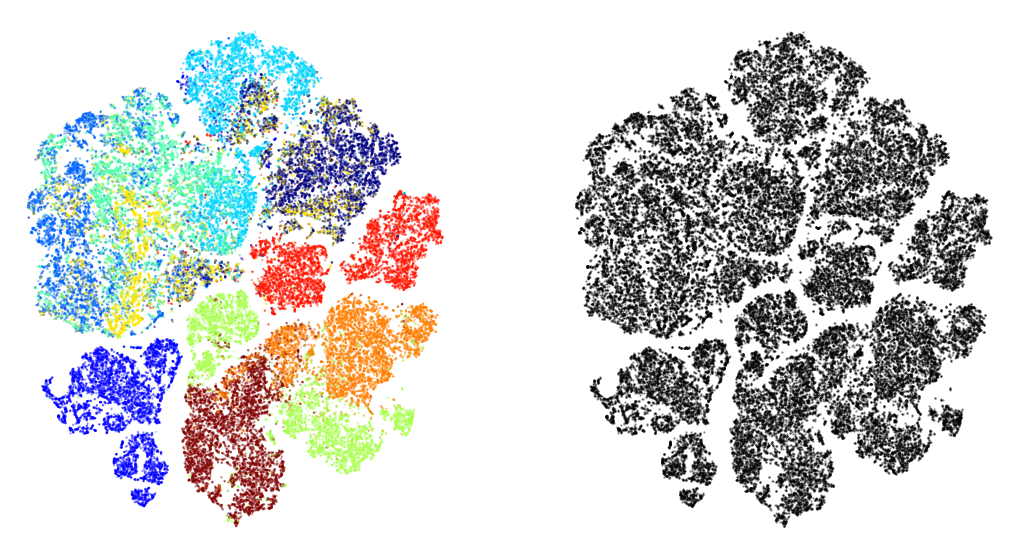

In [ ]:
from varios import grafico

grafico(tsne_results_10 , y, "pretrained_tsne_10")



---



In [ ]:
# use features for clustering
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10, n_init=10, random_state= semilla, init='k-means++', n_jobs=-1)

#features_mnist = np.reshape(features_mnist, newshape=(features_mnist.shape[0], -1)) NOT needed
pred = km.fit_predict(features)

In [ ]:
import metrics

#metrics(y, pred)[0]
print('acc=', metrics.acc(y, pred), 'nmi=', metrics.nmi(y, pred), 'ari=', metrics.ari(y, pred))

acc= 0.5534428571428571 nmi= 0.5983907389189953 ari= 0.43088219740763356


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


.



---



---



# **DCEC training**

In [ ]:
# UPLOAD: ConvAE.py ; DCEC.py ; metric.py ; varios.py ; pretrain_fashion.h5
# /content/
!pip install coclust
import DCEC
from varios import load_fashion_mnist
from varios import metrics
from keras.utils.vis_utils import plot_model


  Created wheel for coclust: filename=coclust-0.2.1-cp36-none-any.whl size=29872 sha256=656a51be93859bf9036dc2eeaba4f3f0246d870edaf0c8b0c4c4a21f55eb0e8b
  Stored in directory: /root/.cache/pip/wheels/cd/d7/68/df601d0b5f8b934cf890dc626c2271df381fb0c3e910b0a34e
Successfully built coclust


In [ ]:
#metrics(y,y1)
y1 = y 
metrics(y,y1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


(1.0, 1.0, 1.0)

In [ ]:
# setting the hyper parameters
##############################
n_clusters = 10
batch_size = 256
maxiter = 2e4
gamma = 0.1
update_interval = 140
tol = 0.001
cae_weights = "pretrain_fashion.h5"
save_dir = "/content/gdrive/My Drive/TFG Estad"
##############################
# DATA:
x , y , target = load_fashion_mnist()

import os
if not os.path.exists(save_dir):
  os.makedirs(save_dir)


4423680/4422102 [==============================] - 0s 0us/step
fashion_mnist; x: (70000, 28, 28, 1)
fashion_mnist; y: (70000,)


In [ ]:
# prepare the DCEC model
dcec = DCEC.DCEC(input_shape=x.shape[1:], filters=[32, 64, 128, 10], n_clusters=n_clusters)
plot_model(dcec.model, to_file=save_dir + '/dcec_model.png', show_shapes=True)
#dcec.model.summary()

In [ ]:
# begin clustering.
optimizer = 'adam'
dcec.compile(loss=['kld', 'mse'], loss_weights=[gamma, 1], optimizer=optimizer)
history_dcec = dcec.fit(x, y=y, tol=tol, maxiter=maxiter,
             update_interval=update_interval,
             save_dir=save_dir,
             cae_weights=cae_weights)
y_pred = dcec.y_pred

Update interval 140
Save interval 1367.1875
cae_weights is loaded successfully.
Initializing cluster centers with k-means.
Iter 0 : Acc 0.61067 , nmi 0.63118 , ari 0.4753 ; loss= [0 0 0]
saving model to: /content/gdrive/My Drive/TFG Estad/dcec_model_0.h5
Iter 140 : Acc 0.61926 , nmi 0.64521 , ari 0.49101 ; loss= [0.02061 0.08579 0.01203]
Iter 280 : Acc 0.6234 , nmi 0.65167 , ari 0.49894 ; loss= [0.02833 0.14877 0.01345]
Iter 420 : Acc 0.62696 , nmi 0.6565 , ari 0.50507 ; loss= [0.03274 0.18165 0.01457]
Iter 560 : Acc 0.62937 , nmi 0.66026 , ari 0.50858 ; loss= [0.0332  0.18485 0.01471]
Iter 700 : Acc 0.62987 , nmi 0.66115 , ari 0.51017 ; loss= [0.03334 0.18627 0.01471]
Iter 840 : Acc 0.6316 , nmi 0.66283 , ari 0.51188 ; loss= [0.03395 0.18158 0.0158 ]
Iter 980 : Acc 0.63201 , nmi 0.66379 , ari 0.51239 ; loss= [0.03199 0.16663 0.01532]
Iter 1120 : Acc 0.6332 , nmi 0.66516 , ari 0.51389 ; loss= [0.03068 0.16229 0.01445]
Iter 1260 : Acc 0.63456 , nmi 0.66613 , ari 0.51538 ; loss= [0.0318 

In [ ]:
acc, nmi, ari = metrics(y, y_pred)

print( [acc, nmi, ari] )


[0.6360142857142858, 0.6616783200526366, 0.511795166122067]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
from tensorflow.keras.models import Model
feature_model = Model(inputs=dcec.model.input, outputs=dcec.model.get_layer(name='embedding').output)
features = feature_model.predict(x)
print('feature shape=', features.shape)

feature shape= (70000, 10)


In [ ]:
from sklearn.manifold import TSNE
tsne_dcec = TSNE( n_components= 2, perplexity= 25.0, learning_rate= 10.0, n_iter=5000, random_state= 1997, n_iter_without_progress=200 )
tsne_results_dcec = tsne_dcec.fit_transform(features)
# It requires several hours!

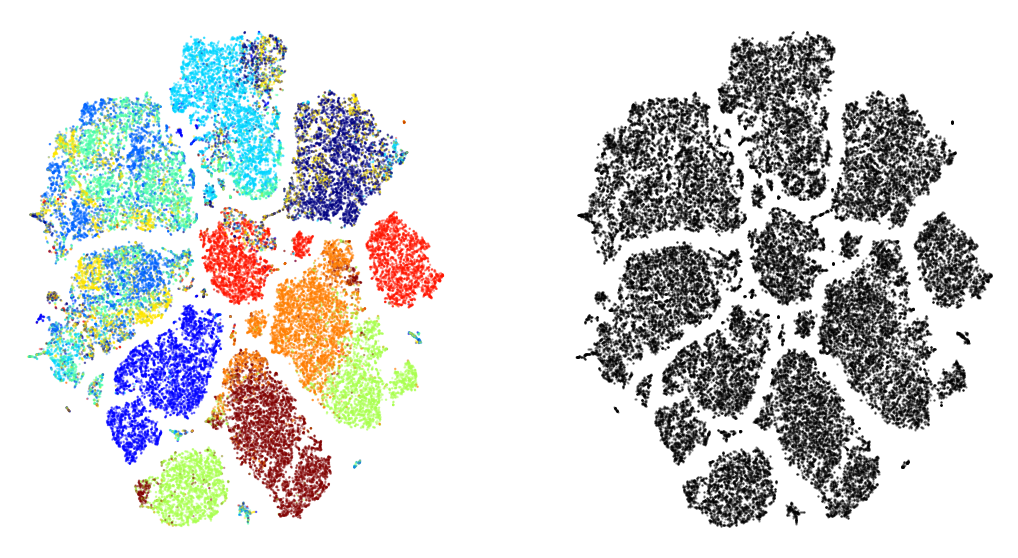

In [ ]:
from varios import grafico

grafico(tsne_results_dcec , y, "pretrained_tsne_10")



---





---



In [ ]:
dcec.model.load_weights('dcec_fashion.h5')

In [ ]:
from tensorflow.keras.models import Model
feature_model_dcec = Model(inputs=dcec.model.input, outputs=dcec.model.get_layer(name='embedding').output)
features_dcec = feature_model.predict(x)
print('feature shape=', features.shape)

feature shape= (70000, 10)


In [ ]:
import umap
t1 = time()
fit = umap.UMAP( n_neighbors=15, min_dist=0.1, n_components=2, metric="euclidean", random_state=semilla)
umap_cae = fit.fit_transform(features)
umap_dcec = fit.fit_transform(features_dcec)
print( time() - t1 )

195.91607022285461


In [ ]:
from varios import grafico_comp

def grafico_comp(space1, space2, target, fitxer=''):
    
  import matplotlib.pyplot as plt  
  
  fig, (ax1, ax2) = plt.subplots( nrows=1,ncols=2,figsize=(18, 10) )

  ax1.scatter( space1[:,0], space1[:,1], c= target, cmap=plt.cm.get_cmap('jet', 10), s=2 ,alpha=0.3 ) 
  ax1.axis('off')
  ax1.set_title("Pretained CAE", fontsize=14)

  ax2.scatter( space2[:,0], space2[:,1],  c= target, cmap=plt.cm.get_cmap('jet', 10), s=2 ,alpha=0.3 ) 
  ax2.axis('off')
  ax2.set_title("DCEC", fontsize=14)

  fig.savefig( fitxer )
  plt.show()

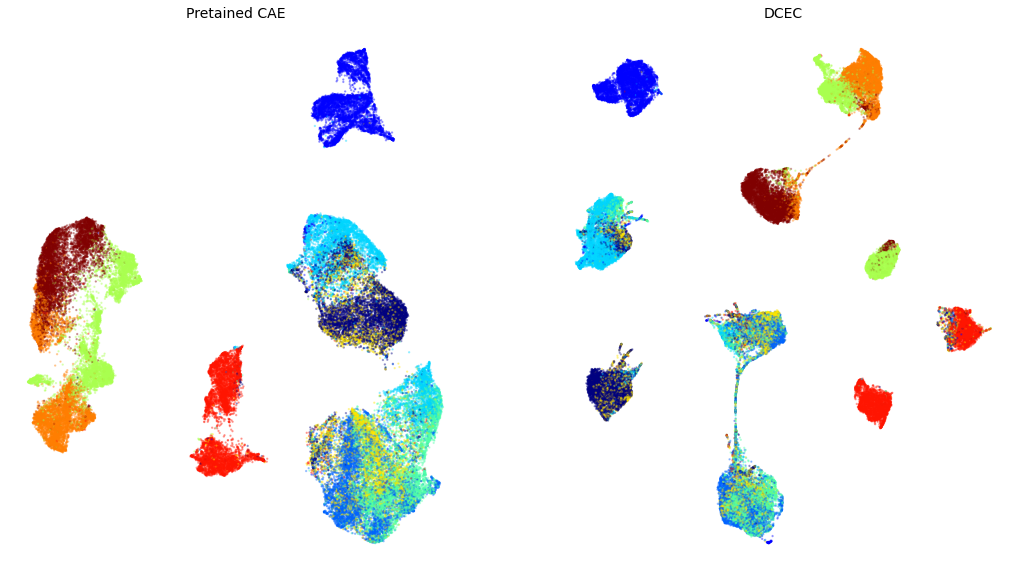

In [ ]:
grafico_comp(umap_cae, umap_dcec, y, fitxer='umap_dcec')



*   It is clear that the clustering layer help to separate the observations between clusters, but this separation does not have to be correct. 
*   The visualisation using UMAP and t-SNE is very different as regards the global structure. But the clusters are very similar: Those categories that are separated into several pieces, or mixed with several groups, are using both tsne and umap.




---



**USING GAMMA = 1 -> the clustering and the mse layers have the same importance**

In [ ]:
gamma = 1 

In [ ]:
dec = DCEC.DCEC(input_shape=x.shape[1:], filters=[32, 64, 128, 10], n_clusters=n_clusters)
plot_model(dec.model, to_file=save_dir + '/dec_model.png', show_shapes=True)

In [ ]:
# begin clustering.
optimizer = 'adam'
dec.compile(loss=['kld', 'mse'], loss_weights=[gamma, 1], optimizer=optimizer)
dec.fit(x, y=y, tol=tol, maxiter=maxiter,
             update_interval=update_interval,
             save_dir=save_dir,
             cae_weights="pretrain_fashion.h5")
y_pred = dec.y_pred

In [ ]:
acc, nmi, ari = metrics(y, y_pred)

print( [acc, nmi, ari] )


[0.5609142857142857, 0.6072541335002102, 0.4471530111529909]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
from tensorflow.keras.models import Model
feature_dec_model = Model(inputs=dec.model.input, outputs=dec.model.get_layer(name='embedding').output)
features_dec = feature_dec_model.predict(x)
print('feature shape=', features_dec.shape)

feature shape= (70000, 10)


In [ ]:
import umap
fit = umap.UMAP( n_neighbors=15, min_dist=0.1, n_components=2, metric="euclidean", random_state=semilla)
#umap_cae = fit.fit_transform(features)
umap_dec = fit.fit_transform(features_dec)

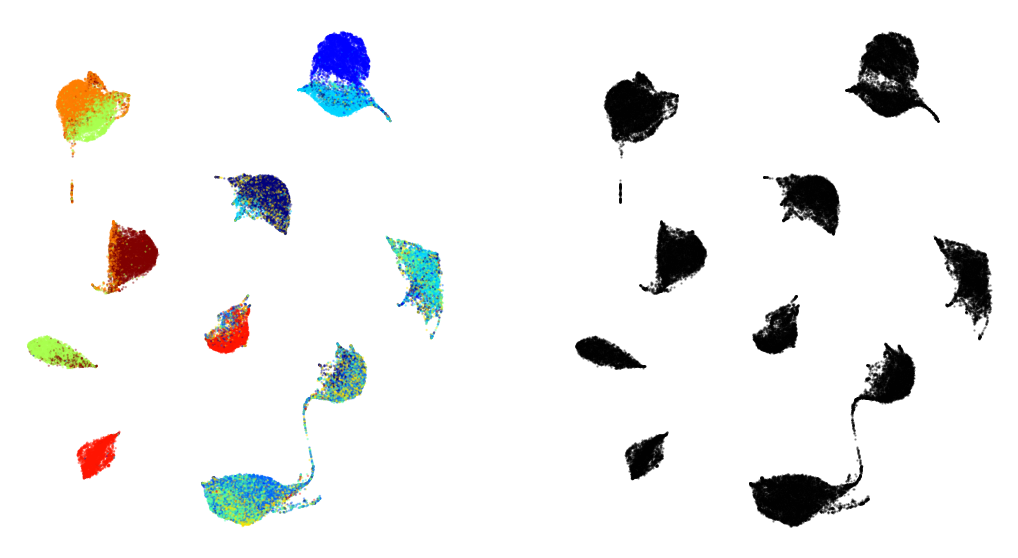

In [ ]:
from varios import grafico
grafico(umap_dec, y, fitxer='umap_dec')



---





---



In [ ]:
whos

Variable                       Type                          Data/Info
----------------------------------------------------------------------
DCEC                           module                        <module 'DCEC' from '/content/DCEC.py'>
InputSpec                      type                          <class 'tensorflow.python<...>ne.input_spec.InputSpec'>
K                              module                        <module 'tensorflow.keras<...>ras/backend/__init__.py'>
KMeans                         type                          <class 'sklearn.cluster._kmeans.KMeans'>
Layer                          type                          <class 'tensorflow.python<...>engine.base_layer.Layer'>
Model                          type                          <class 'tensorflow.python<...>s.engine.training.Model'>
accuracy                       function                      <function accuracy at 0x7f009c19cf28>
adjusted_mutual_info_score     function                      <function adjusted_mutual<.



---



.



---



# **MNIST**

In [ ]:
from datasets import load_mnist
from varios import CAE_Guo
x_mnist, y_mnist = load_mnist()

11493376/11490434 [==============================] - 0s 0us/step
MNIST: (70000, 28, 28, 1)


In [ ]:
model_mnist = CAE_Guo(input_shape=x_mnist.shape[1:], filters=[32, 64, 128, 10])
plot_model(model_mnist, to_file= save_dir + '/pretrain_mnist.png', show_shapes=True)
#model_mnist.summary()

In [ ]:
# compile the model and callbacks
optimizer = 'adam'
model_mnist.compile(optimizer=optimizer, loss='mse')
from keras.callbacks import CSVLogger
csv_logger = CSVLogger(save_dir + '/pretrain_mnist.csv')

In [ ]:
epochs = 400

In [ ]:
# begin training
t0 = time()
model_mnist.fit(x_mnist, x_mnist, batch_size=batch_size, epochs=epochs, callbacks=[csv_logger])
print('Training time: ', time() - t0)
model_mnist.save(save_dir + '/pretrain_mnist.h5')

In [ ]:
# extract features
feature_model = Model(inputs=model_mnist.input, outputs=model_mnist.get_layer(name='embedding').output)
features_mnist = feature_model.predict(x_mnist)
print('feature shape=', features_mnist.shape)

feature shape= (70000, 10)


In [ ]:
# use features for clustering
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10, n_init=10, random_state= semilla, init='k-means++', n_jobs=-1)

#features_mnist = np.reshape(features_mnist, newshape=(features_mnist.shape[0], -1)) NOT needed
pred = km.fit_predict(features_mnist)

In [ ]:
import metrics

#metrics(y, pred)[0]
print('acc=', metrics.acc(y_mnist, pred), 'nmi=', metrics.nmi(y_mnist, pred), 'ari=', metrics.ari(y_mnist, pred))

acc= 0.8365857142857143 nmi= 0.7882109904357436 ari= 0.7442446166417007


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
fit = umap.UMAP( n_neighbors=15, min_dist=0.1, n_components=2, metric="euclidean", random_state=semilla)
umap_cae_mnist = fit.fit_transform(features_mnist)

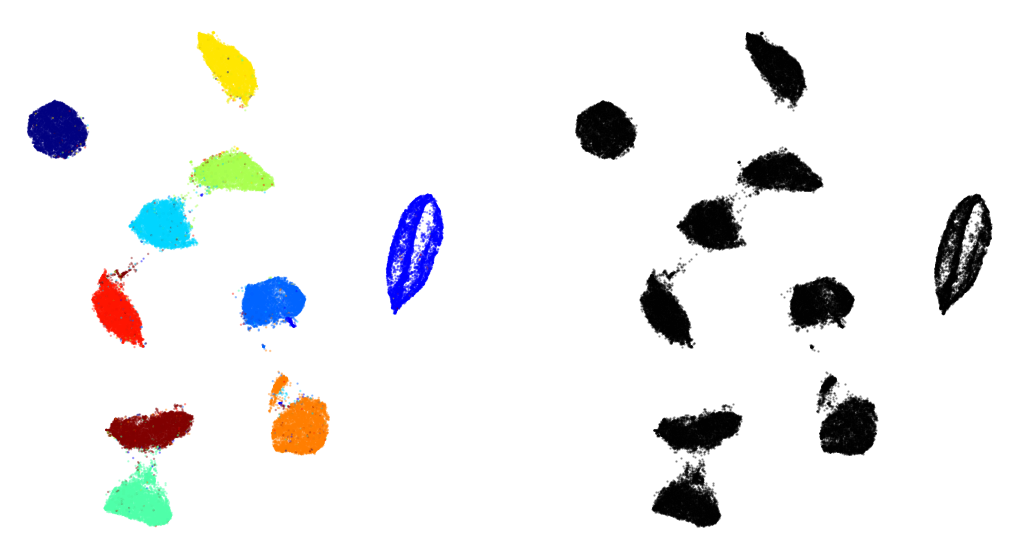

In [ ]:
from varios import grafico

grafico(umap_cae_mnist , y_mnist, "pretrained_umap_mnist")

In [ ]:
fit = umap.UMAP( n_neighbors=30, min_dist=0, n_components=2, metric="euclidean", random_state=semilla)
umap_cae_mnist = fit.fit_transform(features_mnist)

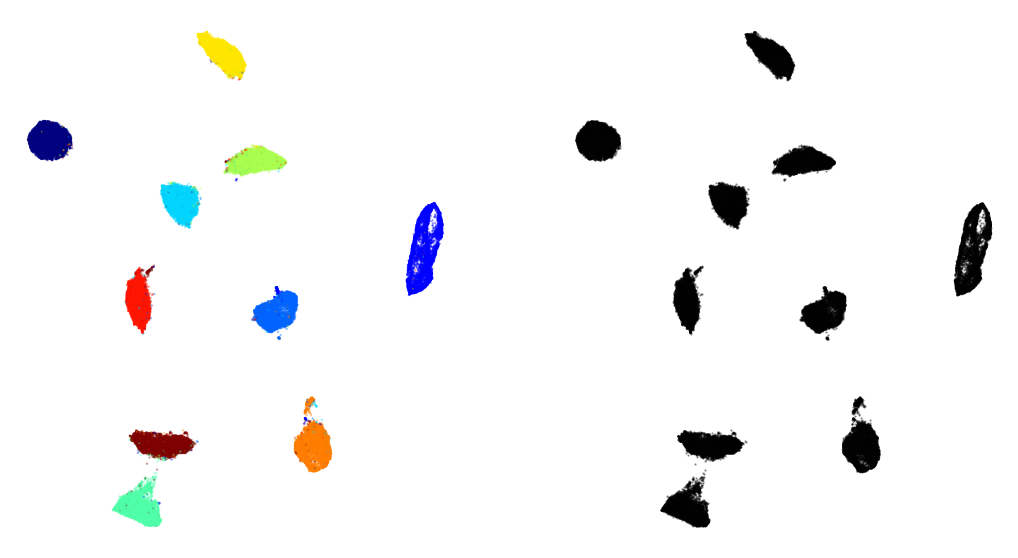

In [ ]:
grafico(umap_cae_mnist , y_mnist, "pretrained_umap_mnist")

The global structure is completely lost?



---



# **DCEC MNIST**



---



In [ ]:
# prepare the DCEC model
dcec_mnist = DCEC.DCEC(input_shape=x_mnist.shape[1:], filters=[32, 64, 128, 10], n_clusters=n_clusters)
plot_model(dcec_mnist.model, to_file=save_dir + '/dcec_mnist.png', show_shapes=True)
#dcec_mnist.model.summary()

In [ ]:
# begin clustering.
optimizer = 'adam'
dcec_mnist.compile(loss=['kld', 'mse'], loss_weights=[gamma, 1], optimizer=optimizer)
dcec_mnist.fit(x_mnist, y=y_mnist, tol=tol, maxiter=maxiter,
             update_interval=update_interval,
             save_dir=save_dir,
             cae_weights="pretrain_mnist.h5")
y_pred = dcec_mnist.y_pred

In [ ]:
print('acc=', metrics.acc(y_mnist, y_pred), 'nmi=', metrics.nmi(y_mnist, y_pred), 'ari=', metrics.ari(y_mnist, y_pred))

acc= 0.8924142857142857 nmi= 0.8898132066225067 ari= 0.8552991661700045


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)




---



In [ ]:

feature_mnist_dcec = Model(inputs=dcec_mnist.model.input, outputs=dcec_mnist.model.get_layer(name='embedding').output)
features_mnist_dcec = feature_mnist_dcec.predict(x_mnist)
print('feature shape=', features_mnist_dcec.shape)

feature shape= (70000, 10)


In [ ]:

fit = umap.UMAP( n_neighbors=15, min_dist=0.1, n_components=2, metric="euclidean", random_state=semilla)
#umap_cae_mnist = fit.fit_transform(features_mnist)
umap_dcec_mnist = fit.fit_transform(features_mnist_dcec)


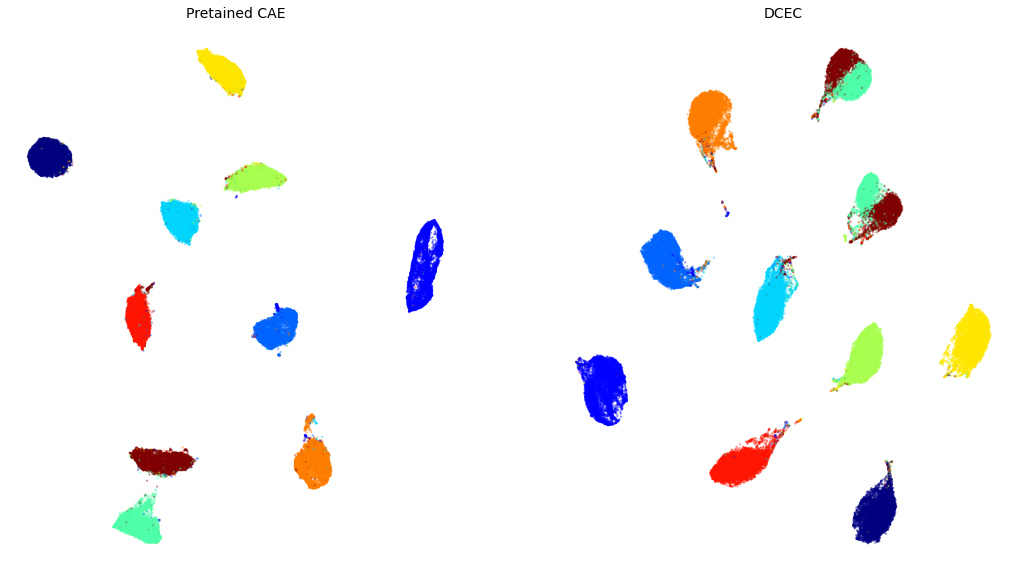

In [ ]:
grafico_comp(umap_cae_mnist, umap_dcec_mnist, y_mnist, fitxer='umap_dcec_mnist')

**USING GAMMA = 1 -> the clustering and the mse layers have the same importance**

In [ ]:
gamma = 1 

In [ ]:
dec_mnist = DCEC.DCEC(input_shape=x.shape[1:], filters=[32, 64, 128, 10], n_clusters=n_clusters)
#plot_model(dec_mnist.model, to_file=save_dir + '/dec_model.png', show_shapes=True)

In [ ]:
# begin clustering.
optimizer = 'adam'
dec_mnist.compile(loss=['kld', 'mse'], loss_weights=[gamma, 1], optimizer=optimizer)
dec_mnist.fit(x_mnist, y=y_mnist, tol=tol, maxiter=maxiter,
             update_interval=update_interval,
             save_dir=save_dir,
             cae_weights="pretrain_mnist.h5")
y_pred = dec_mnist.y_pred

In [ ]:
acc, nmi, ari = metrics(y_mnist, y_pred)

print( [acc, nmi, ari] )


[0.5417571428571428, 0.5195810548102794, 0.37921285981251873]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


There is a lot of difference in the performance w.r.t the DCEC with Gamma=0.1

In [ ]:
feature_mnist_dec = Model(inputs=dec_mnist.model.input, outputs=dec_mnist.model.get_layer(name='embedding').output)
features_mnist_dec = feature_mnist_dec.predict(x_mnist)
print('feature shape=', features_mnist_dec.shape)

feature shape= (70000, 10)


In [ ]:
fit = umap.UMAP( n_neighbors=15, min_dist=0.1, n_components=2, metric="euclidean", random_state=semilla)
#umap_cae_mnist = fit.fit_transform(features_mnist)
umap_dec_mnist = fit.fit_transform(features_mnist_dec)


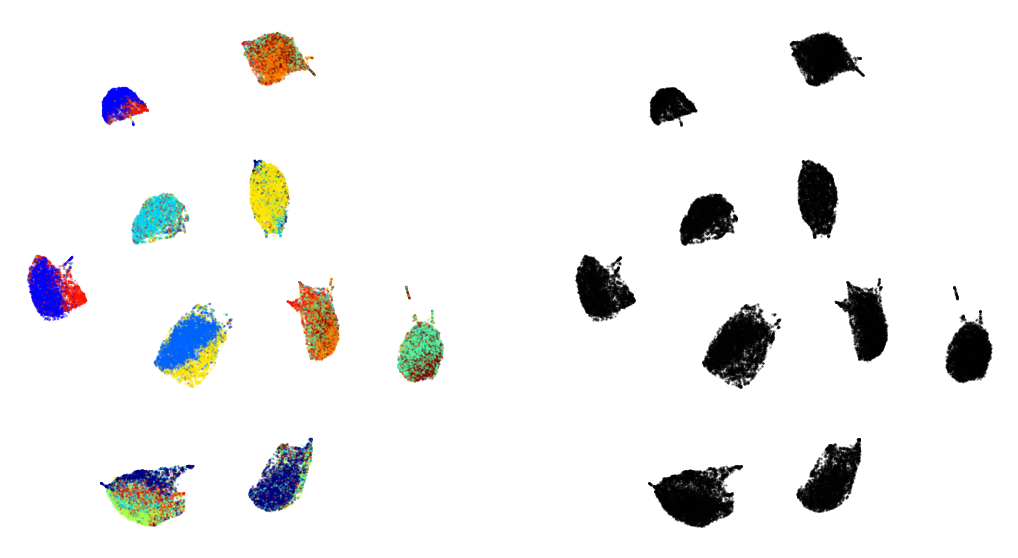

In [ ]:
grafico(umap_dec_mnist, y_mnist, fitxer='umap_dec_mnist')



---



.



---



# Using another CAE architecture

For Fashion dataset

In [ ]:
from varios import CAE_ampliado

In [ ]:
CAE.summary()

In [ ]:
# setting the hyper parameters
##############################
n_clusters = 10
batch_size = 256
maxiter = 2e4
gamma = 0.1
update_interval = 140
tol = 0.001
epochs= 150
semilla = 1997
#cae_weights = "pretrain_fashion.h5"
save_dir = "/content/gdrive/My Drive/TFG Estad"
##############################
# DATA:
from varios import load_fashion_mnist
x , y , target = load_fashion_mnist()

import os
if not os.path.exists(save_dir):
  os.makedirs(save_dir)


4423680/4422102 [==============================] - 0s 0us/step
fashion_mnist; x: (70000, 28, 28, 1)
fashion_mnist; y: (70000,)


In [ ]:
from datasets import load_mnist
x , y = load_mnist()

In [ ]:
optimizer = 'adam'
CAE.compile(optimizer=optimizer, loss='mse')
from keras.callbacks import CSVLogger
from  tensorflow.keras.callbacks import EarlyStopping
csv_logger = CSVLogger(save_dir + '/pretrain_fashion_ampliado.csv' )
earlyStop = EarlyStopping( monitor='loss', patience=10 )

In [ ]:
# begin training
CAE.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=[ csv_logger, earlyStop ])
CAE.save(save_dir + '/pretrain_mnist_ampliado.h5')

In [ ]:
# extract features
feature_model = Model(inputs=CAE.input, outputs=CAE.get_layer(name='embedding').output)
features = feature_model.predict(x)
print('feature shape=', features.shape)

feature shape= (70000, 10)


In [ ]:
# use features for clustering
from sklearn.cluster import KMeans
km = KMeans(n_clusters=n_clusters)

In [ ]:
#features = np.reshape(features, newshape=(features.shape[0], -1))
#! pip install coclust
pred = km.fit_predict(features)
#import metrics
print('acc=', metrics.acc(y, pred), 'nmi=', metrics.nmi(y, pred), 'ari=', metrics.ari(y, pred))

In [ ]:
from umap import UMAP
fit = UMAP( n_neighbors=15, min_dist=0.1, n_components=2, metric="euclidean", random_state=semilla)
umap_fashion_amp = fit.fit_transform(features)


fashion dataset

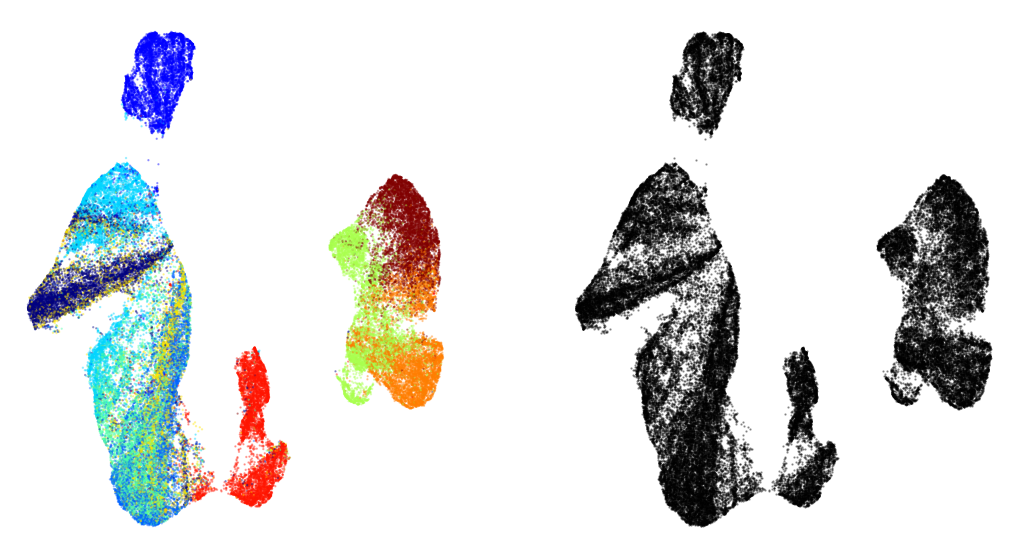

In [ ]:
from varios import grafico
grafico(umap_fashion_amp, y , fitxer='umap_fashion_amp')

mnist dataset

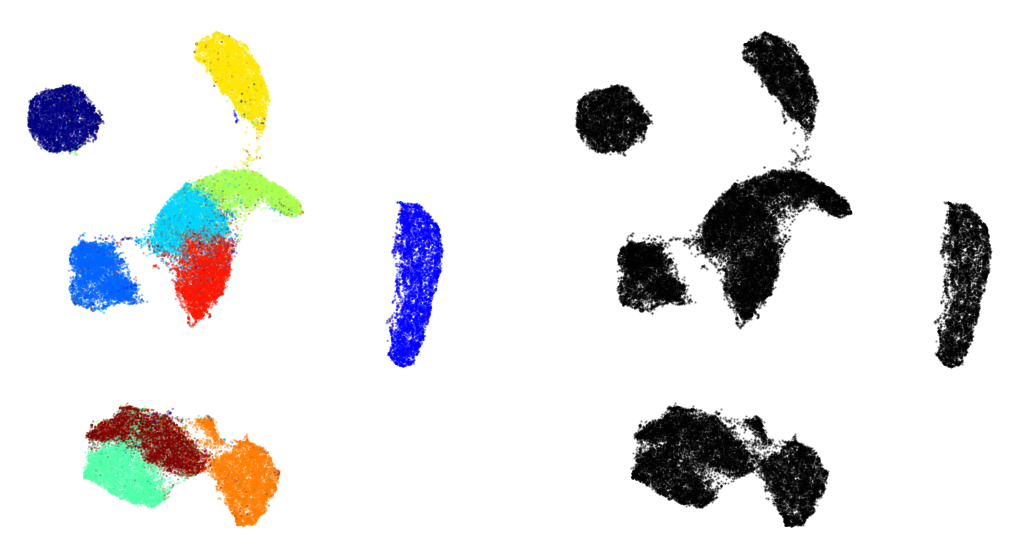

In [ ]:
umap_mnist_amp = fit.fit_transform(features)
grafico(umap_mnist_amp, y , fitxer='umap_mnist_amp')

# **DCEC with this different architecture**

In [ ]:
import DCEC

In [ ]:
# prepare the DCEC model
dcec_mnist_amp = DCEC.DCEC(input_shape=x_mnist.shape[1:], filters=[32, 64, 128, 10], n_clusters=n_clusters)
plot_model(dcec_mnist_amp.model, to_file=save_dir + '/dcec_mnist_amp.png', show_shapes=True)
#dcec_mnist.model.summary()

In [ ]:
# begin clustering.
optimizer = 'adam'
dcec_mnist_amp.compile(loss=['kld', 'mse'], loss_weights=[gamma, 1], optimizer=optimizer)
dcec_mnist_amp.fit(x_mnist, y=y_mnist, tol=tol, maxiter=maxiter,
             update_interval=update_interval,
             save_dir=save_dir,
             cae_weights="pretrain_mnist.h5")
y_pred = dcec_mnist_amp.y_pred

In [ ]:
print('acc=', metrics.acc(y_mnist, y_pred), 'nmi=', metrics.nmi(y_mnist, y_pred), 'ari=', metrics.ari(y_mnist, y_pred))

## Definition of the DCEC network as stated in Guo et. al.

In [ ]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
class DCEC(object):
    def __init__(self,
                 input_shape,
                 filters=[32, 64, 128, 10],
                 n_clusters=10,
                 alpha=1.0):

        super(DCEC, self).__init__()

        self.n_clusters = n_clusters
        self.input_shape = input_shape
        self.alpha = alpha
        self.pretrained = False
        self.y_pred = []

        self.cae = CAE(input_shape, filters)
        hidden = self.cae.get_layer(name='embedding').output
        self.encoder = Model(inputs=self.cae.input, outputs=hidden)

        # Define DCEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(hidden)
        self.model = Model(inputs=self.cae.input,
                           outputs=[clustering_layer, self.cae.output])

    def pretrain(self, x, batch_size=256, epochs=200, optimizer='adam', save_dir='results/temp'):
        print('...Pretraining...')
        self.cae.compile(optimizer=optimizer, loss='mse')
        from keras.callbacks import CSVLogger
        csv_logger = CSVLogger(args.save_dir + '/pretrain_log.csv')

        # begin training
        t0 = time()
        self.cae.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=[csv_logger])
        print('Pretraining time: ', time() - t0)
        self.cae.save(save_dir + '/pretrain_cae_model.h5')
        print('Pretrained weights are saved to %s/pretrain_cae_model.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def extract_feature(self, x):  # extract features from before clustering layer
        return self.encoder.predict(x)

    def predict(self, x):
        q, _ = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, loss=['kld', 'mse'], loss_weights=[1, 1], optimizer='adam'):
        self.model.compile(loss=loss, loss_weights=loss_weights, optimizer=optimizer)

    def fit(self, x, y=None, batch_size=256, maxiter=2e4, tol=1e-3,
            update_interval=140, cae_weights=None, save_dir='./results/temp'):

        print('Update interval', update_interval)
        save_interval = x.shape[0] / batch_size * 5
        print('Save interval', save_interval)

        # Step 1: pretrain if necessary
        t0 = time()
        if not self.pretrained and cae_weights is None:
            print('...pretraining CAE using default hyper-parameters:')
            print('   optimizer=\'adam\';   epochs=200')
            self.pretrain(x, batch_size, save_dir=save_dir)
            self.pretrained = True
        elif cae_weights is not None:
            self.cae.load_weights(cae_weights)
            print('cae_weights is loaded successfully.')

        # Step 2: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        self.y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(self.y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 3: deep clustering
        # logging file
        import csv, os
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        logfile = open(save_dir + '/dcec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'L', 'Lc', 'Lr'])
        logwriter.writeheader()

        t2 = time()
        loss = [0, 0, 0]
        index = 0
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q, _ = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                self.y_pred = q.argmax(1)
                if y is not None:
                    acc = np.round(metrics.acc(y, self.y_pred), 5)
                    nmi = np.round(metrics.nmi(y, self.y_pred), 5)
                    ari = np.round(metrics.ari(y, self.y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, L=loss[0], Lc=loss[1], Lr=loss[2])
                    logwriter.writerow(logdict)
                    print('Iter', ite, ': Acc', acc, ', nmi', nmi, ', ari', ari, '; loss=', loss)

                # check stop criterion
                delta_label = np.sum(self.y_pred != y_pred_last).astype(np.float32) / self.y_pred.shape[0]
                y_pred_last = np.copy(self.y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            if (index + 1) * batch_size > x.shape[0]:
                loss = self.model.train_on_batch(x=x[index * batch_size::],
                                                 y=[p[index * batch_size::], x[index * batch_size::]])
                index = 0
            else:
                loss = self.model.train_on_batch(x=x[index * batch_size:(index + 1) * batch_size],
                                                 y=[p[index * batch_size:(index + 1) * batch_size],
                                                    x[index * batch_size:(index + 1) * batch_size]])
                index += 1

            # save intermediate model
            if ite % save_interval == 0:
                # save DCEC model checkpoints
                print('saving model to:', save_dir + '/dcec_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/dcec_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/dcec_model_final.h5')
        self.model.save_weights(save_dir + '/dcec_model_final.h5')
        t3 = time()
        print('Pretrain time:  ', t1 - t0)
        print('Clustering time:', t3 - t1)
        print('Total time:     ', t3 - t0)
